### WineELO - Introduction

5-star rating systems are everywhere we look these days. Uber, Amazon, Google - everywhere you look you see scores out of 5. 

A lot has been said and written about the merit of these 5-star rating systems. Overrepresentation of extreme views in an average rating, different standards across users for and anchoring effects of existing ratings are just a few reasons why we should be wary of these ratings systems. 

So is there an alternative? Well, maybe. In this analysis we are going to explore whether we can transform the 5-star rating system used on the wine review platform Vivino into a rating system that is used in the game of chess: ELO scores.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import time
import datetime
from chessratings import uscf_elo
import wine_data_cleanup as wdc
from matplotlib import pyplot as plt

pd.set_option('mode.chained_assignment', None)

['jana', datetime.date(2021, 5, 10), 1, 2, 2, 0, 0, 2700]
['mickelton', datetime.date(2021, 5, 10), 1, 2, 0, 0, 2, 1300.0]
['roald', datetime.date(2021, 5, 10), 1, 2, 1, 0, 1, 2000.0]


First off, we need a dataset to work with. To this effect, we have scraped all the wine reviews by the top 1,000 Vivino users in the Netherlands (see web_scraper.py for details).

The output files from our web scraper are JSONs. We will combine these JSONs into a single dataframe.

In [2]:
all_wine_reviews = []
for f in os.listdir('raw_data'):
    filename = 'raw_data/' + f
    with open(filename, 'r') as contents:
        user_wine_reviews = json.loads(contents.read())
        user_id = f.split('.')[0]
        scrape_date_unix = os.path.getmtime(filename)
        scrape_date = datetime.datetime.fromtimestamp(scrape_date_unix)
        for u in user_wine_reviews:
            u['reviewer'] = user_id
            u['scrape_date'] = scrape_date
            all_wine_reviews.append(u)

wine_review_df = pd.json_normalize(all_wine_reviews)
wine_review_df.head()

,wine_id,review_date,review_time_ago,vintage,rating,wine_name,producer,region_name,country_name,average_rating,nr_ratings,reviewer,scrape_date
0,159717279,"Thu, Apr 29th at 16:24:15 UTC",2 days ago,2019,3.5,Chianti,Sensi,Chianti,Italy,"3,3",279,30112979,2021-05-01 20:02:23.750630
1,157184020,"Wed, Apr 28th at 15:59:40 UTC",3 days ago,2018,3.0,La Chapelle de Pied Vaurias Côtes-du-Rhône,Vignerons de l'Enclave,Côtes-du-Rhône,France,"3,3",264,30112979,2021-05-01 20:02:23.750630
2,160175069,"Mon, Apr 26th at 16:21:29 UTC",5 days ago,2019,4.0,Valpolicella Ripasso Classico Superiore,Villa Mondi,Valpolicella Ripasso,Italy,"3,7",89,30112979,2021-05-01 20:02:23.750630
3,168019781,"Sun, Apr 25th at 15:56:30 UTC",6 days ago,2019,3.0,Vida Libre Blanco,Carlos Ruben,Vino de España,Spain,"0,0",2,30112979,2021-05-01 20:02:23.750630
4,163444783,"Fri, Apr 23rd at 15:53:49 UTC",8 days ago,2020,3.5,MV Malbec,Mendoza Vineyards,Mendoza,Argentina,"3,7",148,30112979,2021-05-01 20:02:23.750630


We can now use our raw datafile to create two tables: 

1. A table containing wine metadata that we can use to slice and dice our results later on
2. A table we can use to feed data into our ELO algorithm

In [3]:
# create a dataframe containing metadata about each wine in our dataset

wine_metadata = wine_review_df[['wine_id', 'vintage', 'wine_name', 'producer', 'region_name', 'country_name', 'nr_ratings']].drop_duplicates()
wine_metadata.set_index('wine_id', inplace=True)
wine_metadata.head()

,vintage,wine_name,producer,region_name,country_name,nr_ratings
wine_id,,,,,,
159717279,2019,Chianti,Sensi,Chianti,Italy,279
157184020,2018,La Chapelle de Pied Vaurias Côtes-du-Rhône,Vignerons de l'Enclave,Côtes-du-Rhône,France,264
160175069,2019,Valpolicella Ripasso Classico Superiore,Villa Mondi,Valpolicella Ripasso,Italy,89
168019781,2019,Vida Libre Blanco,Carlos Ruben,Vino de España,Spain,2
163444783,2020,MV Malbec,Mendoza Vineyards,Mendoza,Argentina,148


Now, we can proceed with our second table - we first need to do some cleanup before we can convert our wine ratings to ELO scores. 

We want a simplified table that contains one row per wine review, with only the necessary information about that review (the reviewer, review date and the rating out of 5).

In [34]:
wine_reviews_cleaned = wdc.clean_wine_reviews(wine_review_df).set_index('wine_id').reset_index()
wine_reviews_cleaned.drop_duplicates(inplace=True)
wine_reviews_cleaned.set_index('wine_id', inplace=True)
wine_reviews_cleaned.head()

,wine_id,reviewer,rating,final_review_date
0,159717279,30112979,3.5,2021-04-29
1,157184020,30112979,3.0,2021-04-28
2,160175069,30112979,4.0,2021-04-26
3,168019781,30112979,3.0,2021-04-25
4,163444783,30112979,3.5,2021-04-23


In [35]:
wine_reviews_cleaned.shape

(650844, 4)

Out of curiosity, let's take a closer look at these reviews - can we learn anything about how 5-star wine ratings are distributed?

<ipython-input-36-4a9332b58049>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


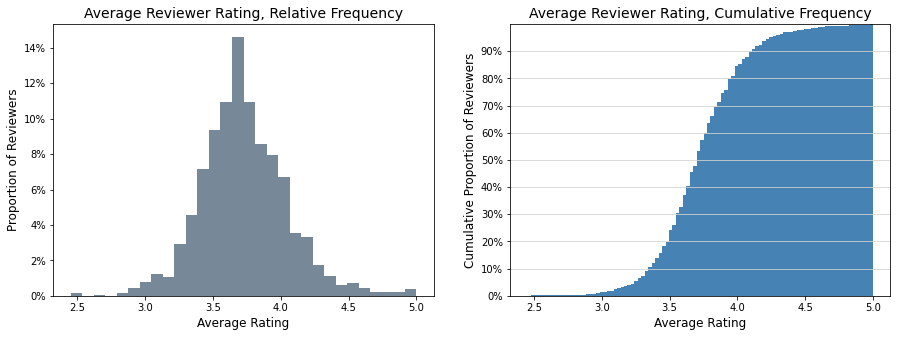

In [36]:
reviewer_distro = wine_reviews_cleaned.groupby('reviewer').agg({'rating': ['describe']})
plot_series = reviewer_distro[('rating', 'describe', 'mean')]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(plot_series, weights=np.zeros_like(plot_series) + 1/plot_series.size, bins=30, color='lightslategray')
plt.title('Average Reviewer Rating, Relative Frequency', fontsize=14)
plt.ylabel('Proportion of Reviewers', fontsize=12)
plt.xlabel('Average Rating', fontsize=12)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

plt.subplot(1, 2, 2)
plt.hist(plot_series, weights=np.zeros_like(plot_series) + 1/plot_series.size, bins=100, color='steelblue', cumulative=True)
plt.title('Average Reviewer Rating, Cumulative Frequency', fontsize=14)
plt.ylabel('Cumulative Proportion of Reviewers', fontsize=12)
plt.xlabel('Average Rating', fontsize=12)
plt.grid(color='lightgrey', linestyle='-', axis='y')
plt.ylim(0, 1)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

plt.show()

This view of the data confirms some of the shortcomings of a system based on average ratings - most importantly that reviewers apply the 5-point rating scale differently. Our dataset supports this, despite consisting of a geographically (and thus culturally) relatively homogenous group of reviewers. The 10% most critical reviewers award wines with less than 3.3/5 points, on average. The 10% most generous reviewers give upwards of 4/5 points on average. This spread is likely to be worse when looking at average review scores from users that are less homogenous (e.g. across different countries). 

While it is possible that more pessimistic reviewers are simply drinking worse wines, this is unlikely to explain for the entirety of the variance here. It stands to reason that some people simply give lower or higher ratings to wines, on average. This has a bearing on average wine ratings also. If a wine has been rated by generous individuals, it will have a higher score than if it has been rated by more critical users.

### From a 5-star rating to an ELO score

We're almost ready to compute our ELO scores. We still, however, need to introduce a few key concepts and do a couple more data transformations. 

ELO scores are normally used to model skill levels in zero-sum games, most famously in chess. The difference in ratings between chess players serves as an indicator for who is more likely to win a match. Each match has one of three possible outcomes: win, draw or loss. Both players' scores are adjusted after a match based on the actual vs. expected outcome. Players will often compete in tournaments that consist of several matches. Here, score updates are typically done after a tournament has been conducted rather than after each individual match. 

We can circumvent many of the problems that plague 5-star rating systems by reducing a reviewer's individual ratings on a given day as a tournament of zero-sum matches. For this purpose, let us propose the following definitions:

- **Player**: a specific wine from a specific vintage
- **Match**: a head-to-head zero-sum comparison of two wines reviewed on a specific day by a specific individual
- **Tournament**: the collection of head-to-head matches by a specific individual on a specific day

The structure above relies on the fairly basic assumption that we can trust a person to be ordinally consistent in the way they rank wines on a given day. If they give one wine 4 stars and another wine 5 on a given evening, we can deduce that the 5-star wine was better than the 4-star one. 

#### Example

A hypothetical example to illustrate:

Reviewer John reviewed 3 different wines on April 29th, 2021: wine A, wine B and wine C. Wine A received 5/5 points and wines B and C received 4/5. As a head-to-head zero sum game these results would look as follows:

- Wine A vs. Wine B: Wine A wins, Wine B loses
- Wine A vs. Wine C: Wine A wins, Wine C loses
- Wine B vs. Wine C: Draw

These three head-to-head **matches** can be grouped together in a **tournament**. We will run these tournaments chronologically. A wine (**player**) that has not participated in a tournament yet will receive a newly initialized ELO score, while a wine that has participated in tournaments in the past will enter a new tournament with its most recent ELO score. 

As we run each tournament, we will store information about each in a lookup table. This will allow us to study how wine ELO scores have evolved over time.


#### Quick note on ELO scores

Before we dive in, it is worth pointing out which implementation of the ELO score algorithm we are using. We are using the most recent (2021) rules used by the US Chess Federation (USCF) as captured in the chessratings package. 


Alright, enough explanation! Let's run the tournaments.

In [6]:
# score lookup table will store information about player performance that we need to initialize ratings as we run tournaments.
score_lookup_table_columns = ['wine_id', 'tournament_date', 'tournament_number', 'elo_rating', 'nr_games_played', 'nr_wins', 'nr_losses', 'reviewer']
score_lookup_table = pd.DataFrame(columns=score_lookup_table_columns)
all_results = wdc.run_tournaments(wine_reviews_cleaned, score_lookup_table)
all_results.to_csv('all_results.csv')
all_results.head()

,wine_id,tournament_date,tournament_number,elo_rating,nr_games_played,nr_wins,nr_losses,reviewer,nr_draws
0,3421,2012-10-21,1,1800.0,3,3,0,226036,0.0
1,1578592,2012-10-21,1,1200.0,3,1,2,226036,0.0
2,4032681,2012-10-21,1,1400.0,3,2,1,226036,0.0
3,1414321,2012-10-21,1,800.0,3,0,3,226036,0.0
0,1607646,2012-11-10,1,1200.0,3,1,2,478177,0.0


Now that we have ELO scores for our wines over time, we can start to explore the results. Let's take a look at the wines with the highest ELO scores.

In [7]:
results_grouped = all_results.groupby('wine_id').agg({'tournament_date': 'max', 'nr_games_played': 'sum', 'nr_wins': 'sum', 'nr_draws': 'sum', 'nr_losses': 'sum', 'tournament_number': 'max'}).reset_index()
results_grouped = pd.merge(results_grouped, all_results[['wine_id', 'tournament_date', 'elo_rating']], how='left', on=['wine_id', 'tournament_date']).drop_duplicates(subset=['wine_id'])

results_grouped = pd.merge(results_grouped, wine_metadata, left_on='wine_id', right_index=True).drop_duplicates(subset=['wine_id'])
results_grouped = results_grouped[['wine_id', 'vintage', 'tournament_date', 'elo_rating', 'tournament_number', 'nr_games_played', 'wine_name', 'producer', 'region_name', 'country_name']]

results_grouped.sort_values(by=['elo_rating'], ascending=False).head(10)

,wine_id,vintage,tournament_date,elo_rating,tournament_number,nr_games_played,wine_name,producer,region_name,country_name
11308,143427191,2006,2018-10-17,2700.0,1,2,Machado,Axe Hill,Calitzdorp,South Africa
55479,2073949,1982,2020-01-05,2700.0,1,2,Rioja Reserva,Marqués de Riscal,Rioja,Spain
72220,4577527,2014,2020-10-11,2700.0,1,2,Brunello di Montalcino,Casanova di Neri,Brunello di Montalcino,Italy
44592,161198046,2012,2020-01-03,2700.0,1,2,Conservation Collection Pinotage,Vriesenhof,Stellenbosch,South Africa
59786,24443897,2013,2020-09-09,2700.0,1,2,Chevalier-Montrachet Grand Cru,Domaine Michel Niellon,Chevalier-Montrachet Grand Cru,France
58829,23516286,2012,2015-07-16,2700.0,1,4,Pernand-Vergelesses Rouge,Domaine Delarche,Pernand-Vergelesses,France
76405,66379423,2015,2020-12-04,2700.0,1,4,Badaceli Tinto,Cal Grau,Priorat,Spain
4382,1239427,1988,2019-03-30,2700.0,1,3,Tenuta Tignanello 'Solaia',Antinori,Toscana,Italy
39998,159595508,2018,2020-02-09,2700.0,1,2,Vignaquadra Falanghina,Collefrisio,Falanghina del Beneventano,Italy
45342,161610521,2018,2019-10-12,2700.0,1,2,Bockstein Riesling GG,Van Volxem,Mosel,Germany


It is apparent from our results that some of the best-performing wines have only participated in a few tournaments. Can we really trust that the best wines in our dataset have only competed in a handful of tournaments and maches?

The USCF can help here with a definition of what constitutes an 'established' rating: at least 25 matches. We will layer on top of this a minimum number of tournaments that we will require eligible wines to have competed in, to reduce the potential impact of a single user rating a wine very highly. 

In [32]:
results_grouped_bounded = results_grouped.loc[(results_grouped['tournament_number'] == 1) & (results_grouped['nr_games_played'] > 5)]

results_grouped_bounded.sort_values(by=['elo_rating'], ascending=False).head(15)

,wine_id,vintage,tournament_date,elo_rating,tournament_number,nr_games_played,wine_name,producer,region_name,country_name
73522,5116259,2014,2018-11-04,2500.000000,1,6,CrossBarn Cabernet Sauvignon,Paul Hobbs,Napa Valley,United States
69141,3928202,2004,2020-02-09,2500.000000,1,6,Black Guts Shiraz,Rusden,Barossa Valley,Australia
75845,6311180,2012,2020-06-15,2265.333333,1,6,Blanc,Roc d'Anglade,Gard,France
68117,37060371,2012,2017-03-23,2200.000000,1,6,Opheliah Maria Bolgheri Superiore,Tenuta Argentiera,Bolgheri,Italy
19445,150341395,1955,2020-05-30,2198.888889,1,7,Anjou,Moulin Touchais,Anjou,France
2426,1161668,2000,2020-10-26,2144.444444,1,6,Vintage Port,Kopke,Porto,Portugal
65328,3174317,2009,2019-09-27,2144.444444,1,6,Montrachet Grand Cru Blanc,Domaine Jacques Prieur,Montrachet Grand Cru,France
14362,145628138,2014,2020-08-06,2101.253651,1,6,Dopoteatro Rosso,Salicutti,Toscana,Italy
77958,7669743,2011,2019-05-28,2100.000000,1,6,Puisseguin Saint-Émilion,Château Saint-Dominique,Puisseguin-Saint-Émilion,France
70592,4228755,2013,2021-01-17,2100.000000,1,8,Napa Valley Chardonnay,Beringer,Napa Valley,United States


We have a winner! The 2010 Nus del Terrer by Vinyes del Terrer from Tarragona, Spain. 




In [28]:
wine_id = '164942645'

one_wine_results = all_results.loc[all_results['wine_id'] == wine_id]
one_wine_results[['wine_id', 'reviewer', 'tournament_date', 'tournament_number', 'nr_games_played', 'nr_wins', 'nr_draws', 'nr_losses', 'elo_rating']]
# one_wine_results = all_results.copy()

,wine_id,reviewer,tournament_date,tournament_number,nr_games_played,nr_wins,nr_draws,nr_losses,elo_rating
3,164942645,1991752,2013-09-23,1,6,1,0.0,5,1014.285714
0,164942645,420965,2013-12-31,2,2,0,0.0,2,984.353741
1,164942645,982011,2013-12-31,3,3,3,0.0,0,1171.700680
1,164942645,2117460,2014-01-18,4,2,2,0.0,0,1254.984219
1,164942645,2437742,2014-03-07,5,3,2,0.0,1,1296.311066
...,...,...,...,...,...,...,...,...,...
0,164942645,7330065,2021-01-01,70,2,2,0.0,0,1437.407133
3,164942645,5498689,2021-01-02,71,3,2,0.0,1,1445.263759
1,164942645,2887311,2021-01-24,72,2,2,0.0,0,1460.219927
1,164942645,10043133,2021-02-20,73,2,1,0.0,1,1436.168150


In [20]:
wine_reviews_cleaned.loc[(wine_reviews_cleaned['final_review_date']=='2019-01-05')&(wine_reviews_cleaned['reviewer'] == '1383329')]

,reviewer,rating,final_review_date
wine_id,,,
157325689,1383329,4.0,2019-01-05
154731482,1383329,3.5,2019-01-05
152394404,1383329,4.5,2019-01-05


In [11]:
wine_reviews_cleaned.loc[(wine_reviews_cleaned['reviewer'] == '938034')]

,reviewer,rating,final_review_date
wine_id,,,
159003841,938034,4.0,2021-01-07
7864169,938034,4.0,2020-12-29
144739656,938034,4.5,2020-12-26
93738964,938034,4.5,2020-12-25
156187525,938034,4.0,2020-12-23
...,...,...,...
3606182,938034,4.5,2013-03-23
1932838,938034,4.0,2013-03-16
1261348,938034,3.5,2013-03-09


In [12]:
reviews_and_scores = pd.merge(one_wine_results, wine_reviews_cleaned, left_on=['reviewer', 'wine_id', 'tournament_date'], right_on=['reviewer', 'wine_id', 'final_review_date'], how='left').drop_duplicates(subset='tournament_number')
reviews_and_scores['rating_cumsum'] = reviews_and_scores['rating'].cumsum()
reviews_and_scores['ma_rating'] = reviews_and_scores['rating_cumsum']/reviews_and_scores['tournament_number']
reviews_and_scores[['wine_id', 'tournament_date', 'tournament_number', 'nr_games_played', 'nr_wins', 'nr_draws', 'nr_losses', 'rating', 'ma_rating', 'elo_rating']]

,wine_id,tournament_date,tournament_number,nr_games_played,nr_wins,nr_draws,nr_losses,rating,ma_rating,elo_rating
0,159115325,2019-02-10,1,3,3,0.0,0,4.0,4.0,2500.000000
1,159115325,2019-02-10,2,2,2,0.0,0,4.0,4.0,2500.000000
2,159115325,2020-02-09,3,2,1,0.0,1,3.0,3.666667,2344.444444


In [13]:
average_ratings = reviews_and_scores.groupby('wine_id').mean('rating')['rating'].reset_index()
elo_vs_rating = pd.merge(average_ratings, multi_tournament_contenders, on='wine_id')

elo_vs_rating.sort_values(by=['elo_rating'], ascending=False).head(15)

NameError: name 'multi_tournament_contenders' is not defined